# Code to take data using the scope and plot relevant histograms. Will output energy resolution and associated errors.

In [1]:
import os
import sys
import pyvisa as visa

import importlib
#importlib.reload(sdaq)
import time
import h5py # This is the python library that creates files/stores data sets
import numpy as np
import matplotlib.pyplot as plt

Define output file and data set names

In [6]:
path='../dataOut/101921_amp1/'
outName='cobalt57_overnighttest'
dsName='run1'

Boolean run options

In [8]:
savePlots=False

In [24]:
f = h5py.File(path+outName+'.h5py', 'a')

### List the data sets within a file (check to make sure your run is there):

In [5]:
list(f.keys())

['run1', 'run1_integral', 'run1_peaks', 'run1_t']

### Data analysis/plotting: assign the data set as the array "plot_array."

In [7]:
plot_array = f[dsName] # insert desired data set name here
time_axis = np.array(f[dsName+"_t"])
traces=len(plot_array)

### Plot 10% of all traces to look at the data and perform a common sense check. Also look for a stretch of data that can be used to determine noise.

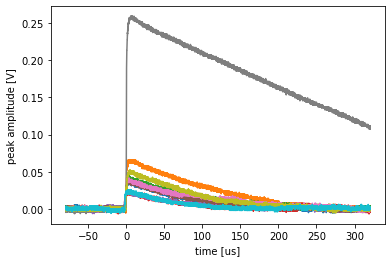

In [9]:
for i in range(int(traces*0.1)):
    plt.plot(time_axis*1e6, plot_array[i])
    
plt.xlabel('time [us]')
plt.ylabel('peak amplitude [V]')

if savePlots:
    plt.savefig(path+outName+'_'+dsName+'_traces.png')

### Plot a histogram of the peaks using matplotlib to get a sense of what the data looks like and where the peak is.

In [25]:
peaks=f[dsName+'_peaks']

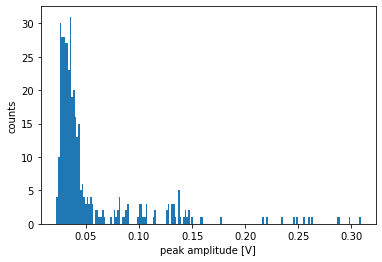

In [12]:
#ultra fine binning for debugging input
plt.hist(peaks, bins=180)
plt.xlabel('peak amplitude [V]')
plt.ylabel('counts')

if savePlots:
    plt.savefig(path+outName+'_'+dsName+'_peakHist.png')


### Plot a more rigorous histogram and fit the data to find the energy resolution.

In [13]:
#AMANDA - optimize x axis range and bin number (so not hardcoded to 1 and 1000)
bins = np.linspace(0,1,1000) # Here, the number of bins has been set to 100 and the length of
# the x axis has been set to one. This can be adjusted; inspect the matplotlib histogram to
# see what the binning / x axis should be.
fit_hist, bins_1 = np.histogram(peaks, bins=bins)
bins_2 = np.array([bins[i] for i in range(len(bins)-1)])
#bins_2 = 0.5*(bins[0:-1]+bins[1:])

### The scipy.optimize function will fit the histogram of your peaks to a Gaussian. The x data is the bins_2 array and the y data is the output from the np.histogram function. In order for the fit to work, you have to make reasonable guesses for the amplitude, the mean, and the sigma of the histogram.
### Change the title of the plot, save figure if it looks good

[1.84632942e+01 3.24117635e-02 6.85500652e-03]
Amplitude = 18, Mu = 0.0324, Sigma = 0.0069
The energy resolution is approximately 49.81 percent.


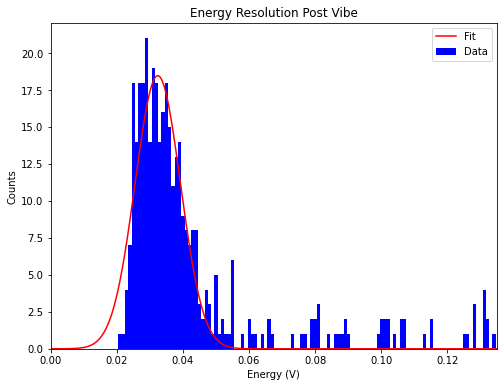

In [16]:
#AMANDA - make separate method so can be used for both peaks and integral

import scipy
from scipy.optimize import curve_fit
import pylab 

x = bins_2
y = fit_hist
xspace = np.linspace(0, 1, 10000) # This creates a smoother plot when plotting the fit

#AMANDA - automate initial parameter setting
# Guesses for p01: [Amplitude, Mu, Sigma]. These guesses must be reasonable.
mean = sum(peaks)/len(peaks)
p01 = [traces, mean, 0.05]

# Define the fit function (a Gaussian)
def Gauss(x, A, mu, sigma):
    return A*np.exp(-(x-mu)**2/(2.0*sigma**2))

#AMANDA - include check that fit converges
# popt returns the best fit values for amplitude, mean, and sigma. pcov returns a covariance
# matrix; the diagonal of this matrix returns the errors associated with the three returned 
# values, which is used to determine the error in the energy resolution.
popt, pcov = curve_fit(Gauss, xdata=bins_2, ydata=fit_hist, p0=p01, maxfev=5000)

plt.figure(figsize = (8, 6))
plt.xlim([0,mean*2.5])

# Plot the data
plt.bar(bins_2, fit_hist, width=bins[1] - bins[0], color='blue', label=r'Data')
# Plot the fit
plt.plot(xspace, Gauss(xspace, *popt), 'r-', label='Fit')
(Amp, Mu, Sigma) = popt
# Print the outputs 
print(popt)
print("Amplitude = %d, Mu = %0.4f, Sigma = %0.4f" %(Amp, Mu, Sigma))
energy_res = (2.355*Sigma*100)/Mu # Calculates energy resolution, 2.355 converts sigma to FWHM
print("The energy resolution is approximately %0.2f percent." %(abs(energy_res)))
plt.legend()
plt.title('Energy Resolution Post Vibe')
plt.xlabel('Energy (V)')
plt.ylabel('Counts')


if savePlots:
    energy_res_str = str(abs(round(energy_res,2)))
    plt.savefig(path+outName+'_'+dsName+'_'+energy_res_str+'enRes.png')
    
plt.show()

### Calculate the errors associated with the energy resolution:

In [15]:
(Amp_err, Mu_err, Sigma_err) = np.sqrt(np.diag(pcov))
# Error propagation
partial_sigma = (2.355*100)/Mu
partial_mu = (2.355*100*Sigma)/(Mu**2)
stdev_er = np.sqrt(((partial_sigma**2)*(Sigma_err**2))+((partial_mu**2)*(Mu_err)**2))
print("Error in amplitude is %0.3f. \nError in mu is %0.6f. \nError in sigma is %0.6f." %(Amp_err, Mu_err, Sigma_err))
print("The error in the energy resolution is %0.5f percent."%(stdev_er))

Error in amplitude is 0.245. 
Error in mu is 0.000105. 
Error in sigma is 0.000105.
The error in the energy resolution is 0.77881 percent.


# Do the same for the trace integral

In [17]:
integ=f[dsName+'_integral']

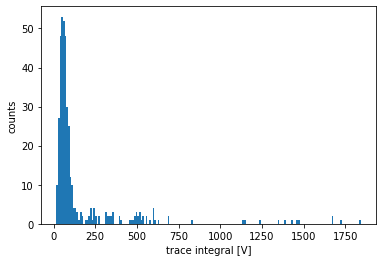

In [18]:
#ultra fine binning for debugging input
plt.hist(integ, bins=180)
plt.xlabel('trace integral [V]')
plt.ylabel('counts')

if savePlots:
    plt.savefig(path+outName+'_'+dsName+'_integHist.png')

Fit integral distribution and pull out mean value

In [19]:
bins_integ = np.linspace(0,3000,100) # Here, the number of bins has been set to 100 and the length of
# the x axis has been set to one. This can be adjusted; inspect the matplotlib histogram to
# see what the binning / x axis should be.
fit_hist2, bins_integ_1 = np.histogram(integ, bins=bins_integ)
bins_integ_2 = np.array([bins_integ[i] for i in range(len(bins_integ)-1)])

[158.4659457   43.98770512  24.26032194]
Amplitude = 158, Mu = 43.9877, Sigma = 24.2603
The energy resolution is approximately 49.81 percent.


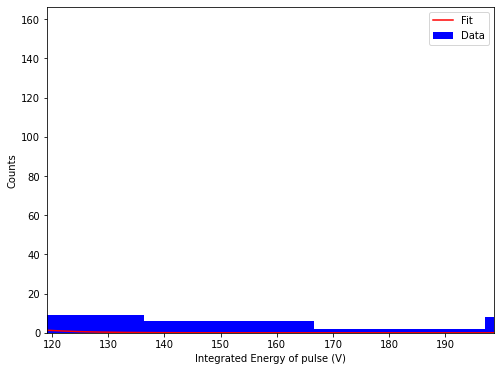

In [20]:
x = bins_integ_2
y = fit_hist2
xspace = np.linspace(0, 3000, 10000) # This creates a smoother plot when plotting the fit

#AMANDA - automate initial parameter setting
# Guesses for p01: [Amplitude, Mu, Sigma]. These guesses must be reasonable.
mean = sum(integ)/len(integ)
p01 = [traces/100, mean, traces/10]

#fit the data
popt, pcov = curve_fit(Gauss, xdata=bins_integ_2, ydata=fit_hist2, p0=p01,maxfev=5000)

plt.figure(figsize = (8, 6))
# Plot the data
plt.bar(bins_integ_2, fit_hist2, width=bins_integ[1] - bins_integ[0], color='blue', label=r'Data')
# Plot the fit
plt.plot(xspace, Gauss(xspace, *popt), 'r-', label='Fit')
(Amp_integ, Mu_integ, Sigma_integ) = popt
# Print the outputs 
print(popt)
print("Amplitude = %d, Mu = %0.4f, Sigma = %0.4f" %(Amp_integ, Mu_integ, Sigma_integ))

plt.xlim([0.75*mean,mean*1.25])
energy_res_integ = (2.355*Sigma*100)/Mu # Calculates energy resolution, 2.355 converts sigma to FWHM
print("The energy resolution is approximately %0.2f percent." %(abs(energy_res_integ)))

plt.legend()
plt.xlabel('Integrated Energy of pulse (V)')
plt.ylabel('Counts')

if savePlots:
    energy_res_str = str(abs(round(energy_res_integ,2)))
    plt.savefig(path+outName+'_'+dsName+'_'+energy_res_str+'enRes_integ.png')
    
plt.show()

Save energy resolution values in txt file

In [32]:
k=open(path+outName+"_"+dsName+"_enRes.txt", "a")
k.write(dsName+'\n')
k.write("PEAKS\n")
k.write("Amplitude = %d \nMu = %0.4f \nSigma = %0.4f" %(Amp, Mu, Sigma)+"\n")
k.write("Energy resolution = %0.2f" %(abs(energy_res))+"%\n")
k.write("Error in amplitude = %0.3f \nError in mu = %0.6f \nError in sigma = %0.6f" %(Amp_err, Mu_err, Sigma_err)+"\n")
k.write("Error in energy resolution = %0.5f"%(stdev_er)+"%\n")
k.write("INTEGRAL\n")
k.write("Amplitude = %d \nMu = %0.4f \nSigma = %0.4f" %(Amp_integ, Mu_integ, Sigma_integ)+"\n")
k.write("Energy resolution = %0.2f" %(abs(energy_res_integ))+"%\n")
k.close()

### Saving the h5py files as text files

save peaks as list separated by new lines (in scientific notation)

In [27]:
np.savetxt(path+outName+'_'+dsName+"_peaks.txt", peaks)

### If you are done working with a file, ***make sure you close it!*** h5py does not like it when files are left open and you change files and/or kill the kernel.

In [21]:
f.close()

YOU DID IT!!!